In [1]:
# Download dataset
# password "28C#M$b%D12@" (without quotes). 
# !gdown https://drive.google.com/u/0/uc?id=1xPcxljgaGitZ5k9PdFXACi91QMdOagxy&export=download

In [2]:
# !mkdir -p ../data/processed/fingerprint/
# # run on a terminal
# !unzip Children_Multimodal_Biometric_Database.zip -d ../data
# !rm Children_Multimodal_Biometric_Database.zip

In [3]:
# !pip install wsq

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from PIL import Image
import os
import wsq
import glob
from tqdm import tqdm

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
plt.ion()
%matplotlib inline

In [7]:
batch_size = 256*2
valid_size = 0.2
img_size = 28

In [8]:
default = os.getcwd();default

'/root'

In [9]:
# root_dir='/root/fingerprint-classifier/data/Children Multimodal Biometric Database-Distribution/Fingerprint/Session1'
root_dir='/root/data/Children Multimodal Biometric Database-Distribution/Fingerprint/Session1'

In [10]:
# # run once, takes a while
# # im.save(f"../../../../data/processed/fingerprint/{image.split('.')[0]}.jpg")
# os.chdir(root_dir)
# for idx in tqdm(range(len(glob.glob('*.wsq')))):
#     image = glob.glob('*.wsq')[idx]
#     im = Image.open(image)
#     im.save(f"/root/data/processed/fingerprint/{image.split('.')[0]}.jpg")
# os.chdir(default)

In [11]:
def get_dataloader(batch_size, image_size, data_dir='/root/data/processed'):
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    num_train = len(dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    
    train_idx, valid_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, test_loader

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

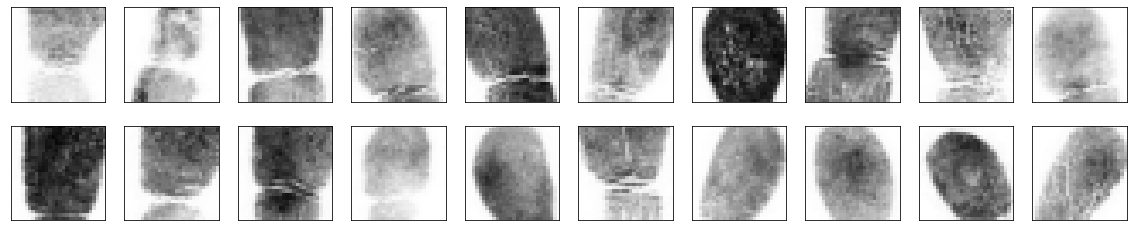

In [13]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
train_loader, _ = get_dataloader(batch_size, img_size)
dataiter = iter(train_loader)
images, _ = dataiter.next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)

In [15]:
model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [16]:
train_loader, test_loader = get_dataloader(batch_size, img_size)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [18]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, loss.item()))
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
#               .format(test_loss, correct, len(test_loader.dataset),
#                       100. * correct / len(test_loader.dataset)))

In [19]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [31]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, figsize=(20, 4))
        axarr[0].imshow(in_grid[:120])
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid[:120])
        axarr[1].set_title('Transformed Images')

In [21]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

Train Epoch: 1 [(0%)]	Loss: 2.384988
Train Epoch: 2 [(0%)]	Loss: 0.015951
Train Epoch: 3 [(0%)]	Loss: 0.003470
Train Epoch: 4 [(0%)]	Loss: 0.000000
Train Epoch: 5 [(0%)]	Loss: 0.002392
Train Epoch: 6 [(0%)]	Loss: 0.002542
Train Epoch: 7 [(0%)]	Loss: 0.000000
Train Epoch: 8 [(0%)]	Loss: 0.000000
Train Epoch: 9 [(0%)]	Loss: 0.007834
Train Epoch: 10 [(0%)]	Loss: 0.002486
Train Epoch: 11 [(0%)]	Loss: 0.003436
Train Epoch: 12 [(0%)]	Loss: 0.000532
Train Epoch: 13 [(0%)]	Loss: 0.001840
Train Epoch: 14 [(0%)]	Loss: 0.003629
Train Epoch: 15 [(0%)]	Loss: 0.000604
Train Epoch: 16 [(0%)]	Loss: 0.001302
Train Epoch: 17 [(0%)]	Loss: 0.000081
Train Epoch: 18 [(0%)]	Loss: 0.001940
Train Epoch: 19 [(0%)]	Loss: 0.000480
Train Epoch: 20 [(0%)]	Loss: 0.002613


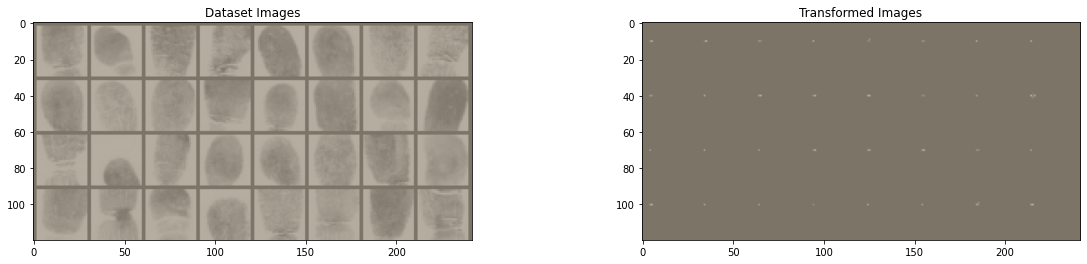

In [32]:
visualize_stn()
plt.ioff()
plt.show()

### Suggestion: (Highly Recommended)
Just use normal augmentation methods